In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from Classes.Domain import layer_3
from Classes.TypesInstant import RecordInfo
from Classes.ExtractSplice import ExtractSplice
from Classes.Func.KitTools import TimeShift, ConfigRead
from Classes.Func.DiagramsGen import PlotMain
from Classes.Func.CalculatePart import FreqPreMethod

In [2]:
file_name = r'C:\Users\HY_Burger\Desktop\Project\extube_sump12.csv'
data_loc = Path(ConfigRead('WaveData', 'Extube'))
vm_list = ['SPONT', 'CPAP', 'APNEA VENTILATION']
def PatientGen(gp, pid):
    df = gp.get_group(pid)
    df = df.reset_index(drop=True)
    rid = df.Record_id.unique()[0]
    pid_obj = layer_3.Patient()
    pid_obj.pid = pid
    pid_obj.end_t = df.endo_t[0]
    pid_obj.end_i = df.endo_end.unique()[0]
    rid_p = RecordInfo(data_loc, pid_obj.end_t, rid)
    rid_p.ParametersInit()
    pid_obj.ridrec = rid_p.rec
    return pid_obj
def RecordGet(pid):
    df = pd.read_csv(file_name)
    df.endo_end = np.where(df.endo_end.str.contains('成功'), 0, 1)
    TimeShift(df, ['endo_t', 'END_t', 'Resp_t'])
    gp = df.groupby('PID')
    id_list = gp.get_group(pid).zdt_1.tolist()
    pid_obj = PatientGen(gp, pid)
    process_0 = ExtractSplice(pid_obj.ridrec)
    process_0.RecBatchesExtract(id_list, 1800)
    pid_obj.resp_l = process_0.RespSplicing(1800, vm_list)
    return pid_obj.resp_l

In [9]:
resp_l = RecordGet(1157905)
rr = np.array([i.rr for i in resp_l])
v_t = np.array([i.v_t_i for i in resp_l])
ve = np.array([i.ve for i in resp_l])
wid_l = [round(i.wid) for i in resp_l]
t_ind = np.array([sum(wid_l[0:i])for i in range(len(wid_l))])
df = pd.DataFrame({'t_ind':t_ind,'rr':rr, 'v_t':v_t, 've':ve})
len(df)

685

ReSample Processing

In [21]:
resp_clip = slice(200,300,1)
interp_rate = 100
re_rate = 4

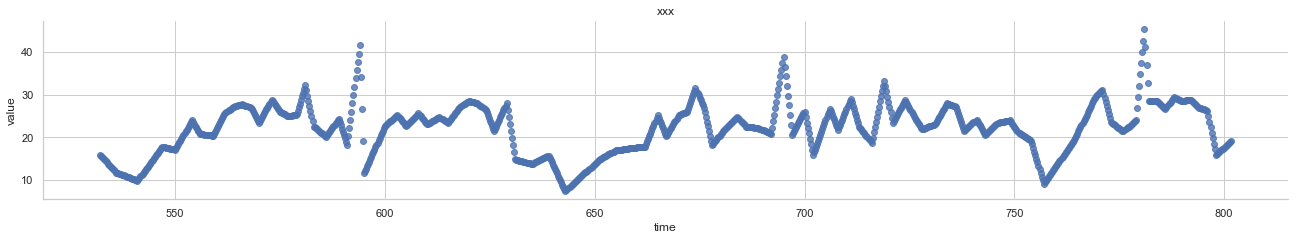

In [22]:
rs_p = FreqPreMethod(df.t_ind, df.rr, resp_clip)
rs_p.InterpValue(interp_rate)
rs_p.Resampling(re_rate)
pl_P = PlotMain()
pl_P.lmplot('time', 'value', rs_p.df, 'xxx')


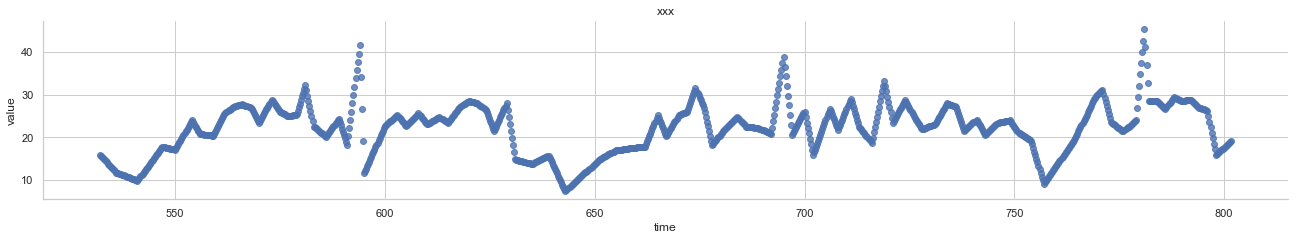